In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14



In [2]:
import numpy as np
import pandas as pd
from collections import namedtuple
import os
import glob

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

In [4]:
from pymono.config import BGO_6x6_fullwrap_4d5k_2MHzDC_PTFE_LUT_NX

In [5]:
from pymono.aux_func import select_image_files, select_image_and_metadata, energy
from pymono.aux_func import select_image_and_lbl, get_energy, get_means_stds
from pymono.aux_func import mean_rms, weighted_mean_and_sigma, energy_h3d, corrected_energy

In [6]:
from pymono.plt_funcs import plot_true_positions, plot_images, plot_energies, plot_corrected_energy
from pymono.plt_funcs import  plot_true_predicted, plotxyz, plot_h3d, plot_energies2, plot_loss
from pymono.plt_funcs import plot_images_ds, histoplot, plot_image_ds, plot_images_ds, plot_image

In [7]:
from pymono.cnn_func import single_run, CNN_basic, CNN_3x3,train_cnn, evaluate_cnn

In [8]:
from pymono.cnn_func import ResNet10

In [9]:
from pymono.mono_dl import MonoDataset, files_list_npy_csv,mono_data_loader

In [10]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


# BGO_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_NX

- Study performance of a BGO monolithic crystal.
- Compare Conv and Resnet

#### Parameters
- 6x6 SiPMs, thus 8x8 matrix
- 50 k photons per point (pure CsI, with ~100 k photons/MeV)
- 0MHzDC (Cold CsI, no DC)
- PTFE wrapping (all sides)
- LUT model
- Nexus simulation 

## Setup

In [12]:
imgs, mdata = select_image_and_lbl(BGO_6x6_fullwrap_4d5k_2MHzDC_PTFE_LUT_NX, 9)

Selected files: img = images_9.npy, metdata = metadata_9.csv


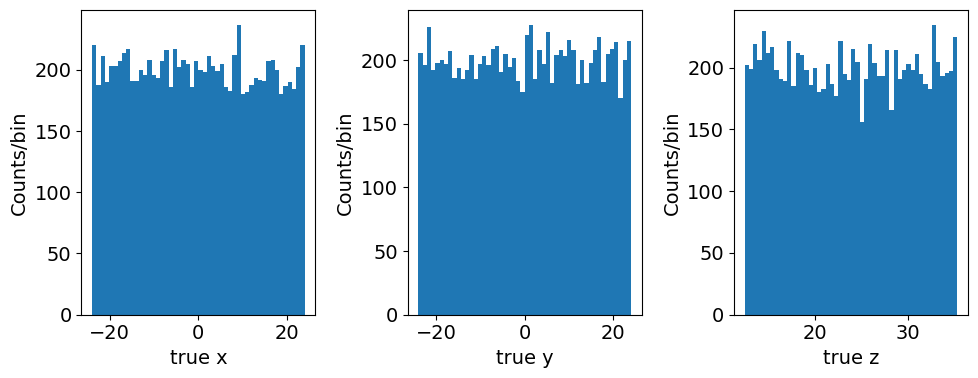

In [13]:
plot_true_positions(mdata)

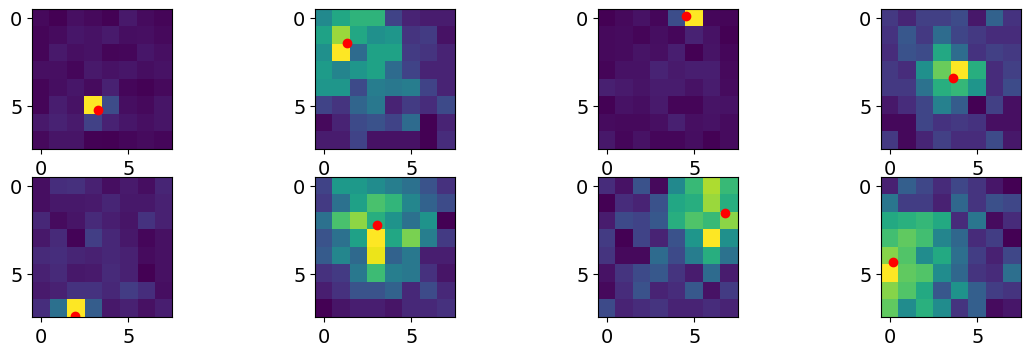

In [14]:
plot_images(imgs, mdata, range(0,8))

In [15]:
imgs[0]

array([[ 13.,   9.,  16.,  13.,  10.,  20.,  14.,  11.],
       [ 11.,  14.,  19.,  17.,  21.,  15.,  16.,  13.],
       [ 11.,  20.,  16.,  17.,  11.,  12.,  19.,  16.],
       [ 16.,  16.,  12.,  20.,  17.,  19.,  15.,  17.],
       [ 11.,  15.,  19.,  14.,  24.,  12.,  10.,  13.],
       [ 11.,  22.,  17., 173.,  47.,  15.,  13.,  18.],
       [ 20.,  25.,  21.,  41.,  25.,  19.,  16.,  18.],
       [ 13.,  18.,  18.,  10.,   9.,  12.,  14.,  12.]], dtype=float32)

In [16]:
np.mean(imgs[0])

18.921875

In [17]:
np.std(imgs[0])

20.40244

In [19]:
energy = get_energy(BGO_6x6_fullwrap_4d5k_2MHzDC_PTFE_LUT_NX, 9)

Selected files: img = images_9.npy, metdata = metadata_9.csv


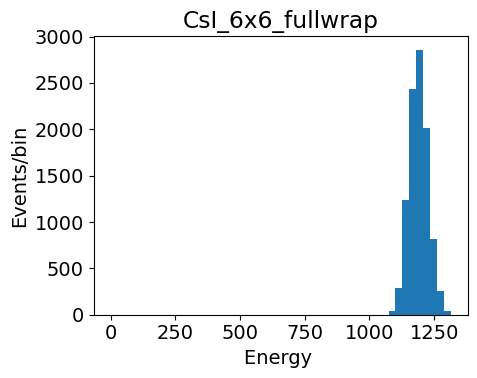

In [20]:
plot_energies2({"CsI_6x6_fullwrap":energy}, xmin=0, xmax=max(energy),num_bins = 50)

In [21]:
mean6x6, std6x6, fwhm6x6 = mean_rms(energy)

print(f"mean = {mean6x6:.2f} resolution (FWHM)  = {100*fwhm6x6:.2f} %")

mean = 1190.71 resolution (FWHM)  = 7.00 %


## Data set

In [22]:
first_file = 0  # initial file indx
last_file  = 100  # lasta file indx
batch_size = 1000  # Batch size
train_fraction=0.7 
val_fraction=0.2


In [23]:
dataset = MonoDataset(BGO_6x6_fullwrap_4d5k_2MHzDC_PTFE_LUT_NX, first_file, last_file)


Running Monoataset with norm = False, resize=False
Loading files with indexes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]


In [24]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 960000 events
 train size = 672000
 val size = 192000
 test size = 96000
 train indices = range(0, 672000)
 val indices = range(672000, 864000)
 test indices = range(864000, 960000)
672000 training events (70.0%)
192000 validation events (20.0%)
96000 test events (10.0%)


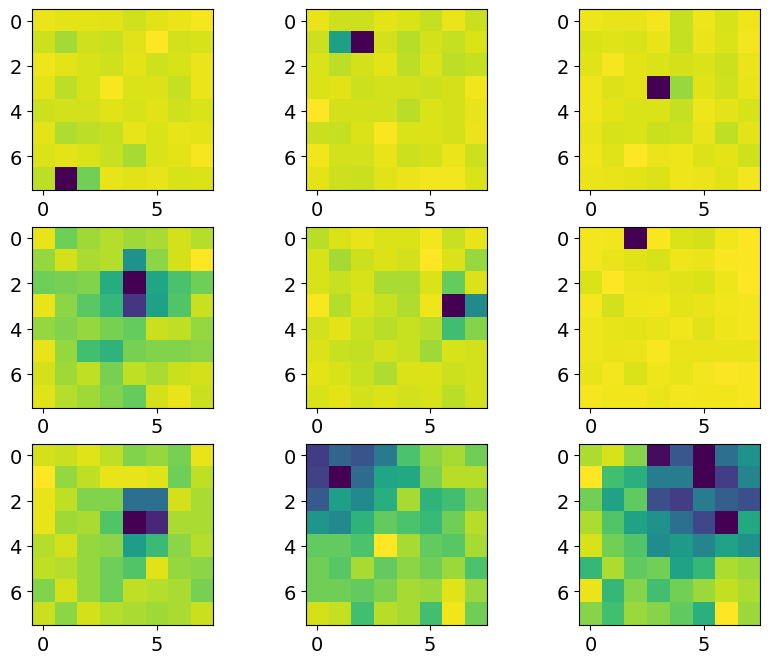

In [25]:
plot_images_ds(dataset, imgs=(0,9), sx=3, figsize=(10, 8))

In [26]:
for images, positions in train_loader:
    print(images.size())
    print(positions.size())
    print(images[0,0,:,:])
    break

torch.Size([1000, 1, 8, 8])
torch.Size([1000, 3])
tensor([[ 16.,  14.,  11.,  13.,  12.,  20.,  14.,   8.],
        [ 10.,  16.,  16.,  14.,  18.,  17.,  11.,  13.],
        [ 12.,  12.,  23.,  18.,  19.,  12.,  19.,  17.],
        [ 10.,  18.,  23., 205.,  15.,  25.,  10.,  11.],
        [ 12.,  22.,  14.,  17.,  19.,  16.,  15.,  23.],
        [ 12.,  12.,  13.,  19.,  20.,  17.,  16.,  16.],
        [ 17.,  11.,  19.,  14.,  22.,  14.,  19.,  10.],
        [ 12.,   9.,  10.,  13.,  15.,  14.,  12.,  13.]])


### Train the network with CNN_basic 

In [38]:
# Load the model.
model = CNN_3x3(dropout=False).to(device)
print(model)

CNN_3x3(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc0): Linear(in_features=512, out_features=3, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
)


In [39]:
# Set up the optimizer and loss function.
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()


In [40]:
single_run(train_loader, device, model, optimizer,criterion)

** Run for 1 event**
epoch = 0
i = 0
images = torch.Size([1000, 1, 8, 8])
labels = torch.Size([1000, 3])
input data shape =>torch.Size([1000, 1, 8, 8])
(8,8,1) => (8,8,64) =>torch.Size([1000, 1, 8, 8])
(8,8,64) => (4,4,128) =>torch.Size([1000, 64, 4, 4])
(4,4,128) => (2,2,256) =>torch.Size([1000, 128, 2, 2])
(2,2,256) => (1,1,512) =>torch.Size([1000, 256, 1, 1])
(1,1,512) => (1,1,3) =>torch.Size([1000, 512, 1, 1])
torch.Size([1000, 3])
outputs = torch.Size([1000, 3])
Train Step 1/672, Loss: 339.183837890625
i = 1
images = torch.Size([1000, 1, 8, 8])
labels = torch.Size([1000, 3])
outputs = torch.Size([1000, 3])
Train Step 2/672, Loss: 277.07940673828125


In [41]:
epochs = 10

In [42]:
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    model, optimizer, device, criterion, 
                                    batch_size, epochs=epochs, iprnt=200)

Training with  ->672000 images
size of train loader  ->672 images
Evaluating with  ->192000 images
size of eval loader  ->192 images
Running for epochs ->10

EPOCH 0
Train Step 200/672, Loss: 2.5779385566711426
Train Step 400/672, Loss: 2.3019638061523438
Train Step 600/672, Loss: 2.3450965881347656
--- EPOCH 0 AVG TRAIN LOSS: 4.9936511019865675
--- EPOCH 0 AVG VAL LOSS: 1.8517891311397154

EPOCH 1
Train Step 200/672, Loss: 1.937609076499939
Train Step 400/672, Loss: 1.805806279182434
Train Step 600/672, Loss: 1.917490839958191
--- EPOCH 1 AVG TRAIN LOSS: 1.907654696809394
--- EPOCH 1 AVG VAL LOSS: 1.9083078522235155

EPOCH 2
Train Step 200/672, Loss: 1.8708758354187012
Train Step 400/672, Loss: 1.8671239614486694
Train Step 600/672, Loss: 2.0543720722198486
--- EPOCH 2 AVG TRAIN LOSS: 1.8052786947006272
--- EPOCH 2 AVG VAL LOSS: 1.6143023576587439

EPOCH 3
Train Step 200/672, Loss: 1.5626806020736694
Train Step 400/672, Loss: 1.7797529697418213
Train Step 600/672, Loss: 1.998100519180

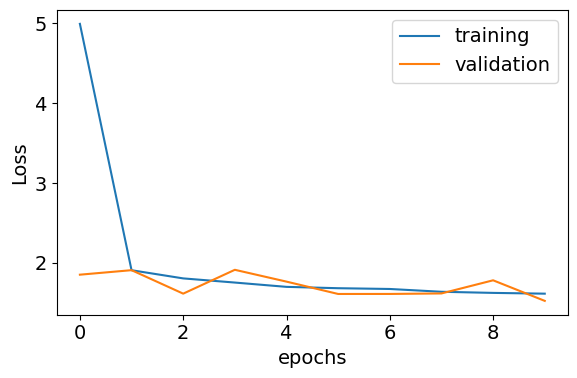

In [43]:
plot_loss(epochs, train_losses, val_losses,figsize=(6, 4))


In [44]:
tdeltas = evaluate_cnn(test_loader, model, device)

In [ ]:
#plot_true_predicted(tdeltas, nbins = 50)

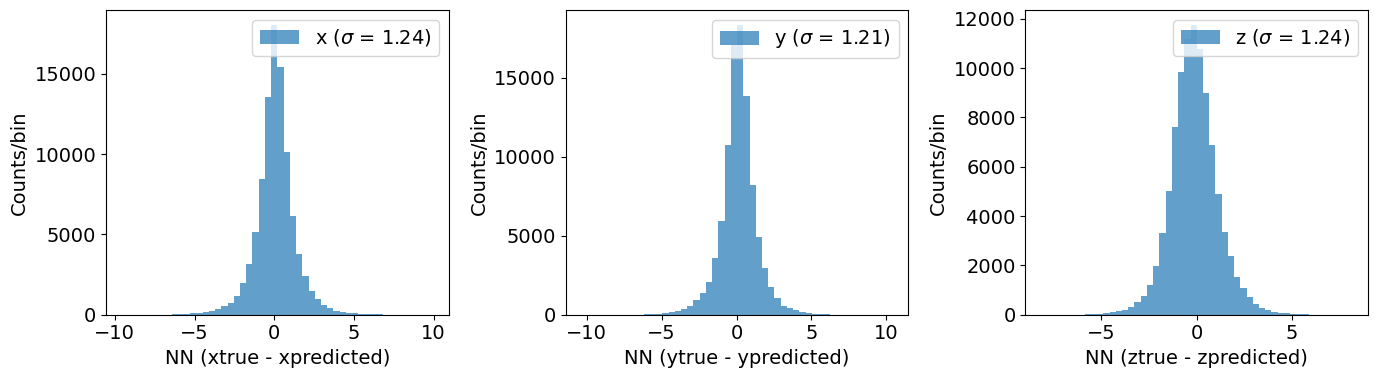

In [45]:
plotxyz(tdeltas, nbins=50)

## Normalize

In [46]:
first_file = 0  # initial file indx
last_file  = 100  # lasta file indx
batch_size = 1000  # Batch size
train_fraction=0.7 
val_fraction=0.2

In [47]:
dataset = MonoDataset(BGO_6x6_fullwrap_4d5k_2MHzDC_PTFE_LUT_NX, 
                      first_file, last_file,
                      norm=True, resize=False, mean=18.6, std=5.0)


Running Monoataset with norm = True, resize=False
Loading files with indexes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]


In [48]:
 data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)   
    

Loaded 960000 events
 train size = 672000
 val size = 192000
 test size = 96000
 train indices = range(0, 672000)
 val indices = range(672000, 864000)
 test indices = range(864000, 960000)
672000 training events (70.0%)
192000 validation events (20.0%)
96000 test events (10.0%)


In [49]:
model = CNN_3x3(dropout=True).to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

CNN_3x3(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc0): Linear(in_features=512, out_features=3, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
)


In [50]:
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    model, optimizer, device, criterion, 
                                    batch_size, epochs=20, iprnt=300)

Training with  ->672000 images
size of train loader  ->672 images
Evaluating with  ->192000 images
size of eval loader  ->192 images
Running for epochs ->20

EPOCH 0
input data shape =>torch.Size([1000, 1, 8, 8])
(8,8,1) => (8,8,64) =>torch.Size([1000, 1, 8, 8])
(8,8,64) => (4,4,128) =>torch.Size([1000, 64, 4, 4])
(4,4,128) => (2,2,256) =>torch.Size([1000, 128, 2, 2])
(2,2,256) => (1,1,512) =>torch.Size([1000, 256, 1, 1])
(1,1,512) => (1,1,3) =>torch.Size([1000, 512, 1, 1])
torch.Size([1000, 3])
Train Step 300/672, Loss: 2.8158814907073975
Train Step 600/672, Loss: 2.692711591720581
--- EPOCH 0 AVG TRAIN LOSS: 6.560137453178565
--- EPOCH 0 AVG VAL LOSS: 1.9437051645169656

EPOCH 1
Train Step 300/672, Loss: 2.7927935123443604
Train Step 600/672, Loss: 2.463186502456665
--- EPOCH 1 AVG TRAIN LOSS: 2.4820905906103907
--- EPOCH 1 AVG VAL LOSS: 1.8514287720123928

EPOCH 2
Train Step 300/672, Loss: 2.2865095138549805
Train Step 600/672, Loss: 2.2615764141082764
--- EPOCH 2 AVG TRAIN LOSS: 2.

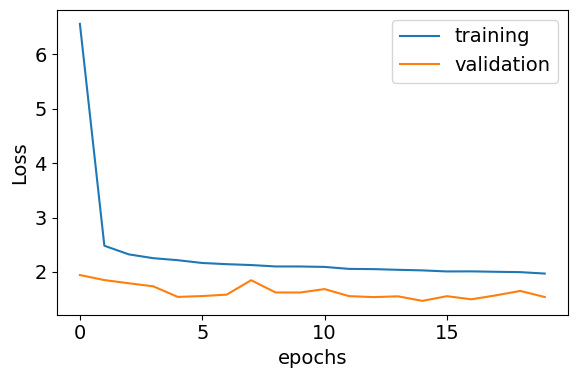

In [51]:
plot_loss(20, train_losses, val_losses,figsize=(6, 4))


In [52]:
tdeltas = evaluate_cnn(test_loader, model, device, pixel_size = 6)


In [54]:
tdeltas

tdeltas(delta_x_NN=array([-0.2645359 , -0.43612874,  0.40252686, ...,  0.00452042,
       -0.07284406, -0.5756078 ], dtype=float32), delta_y_NN=array([-1.6641636 ,  0.319273  ,  0.28944016, ...,  0.12708282,
        1.0413418 ,  3.8648005 ], dtype=float32), delta_z_NN=array([-0.06321812,  0.47595596,  0.7012844 , ..., -1.2072134 ,
        0.40014267,  0.20873642], dtype=float32), delta_x_classical=0.0, delta_y_classical=0.0)

In [55]:
tdeltas.delta_z_NN

array([-0.06321812,  0.47595596,  0.7012844 , ..., -1.2072134 ,
        0.40014267,  0.20873642], dtype=float32)

In [58]:
np.save("/Users/jjgomezcadenas/Projects/pymono/notebooks/delta_z_cnn_bgo.npy", tdeltas.delta_z_NN)

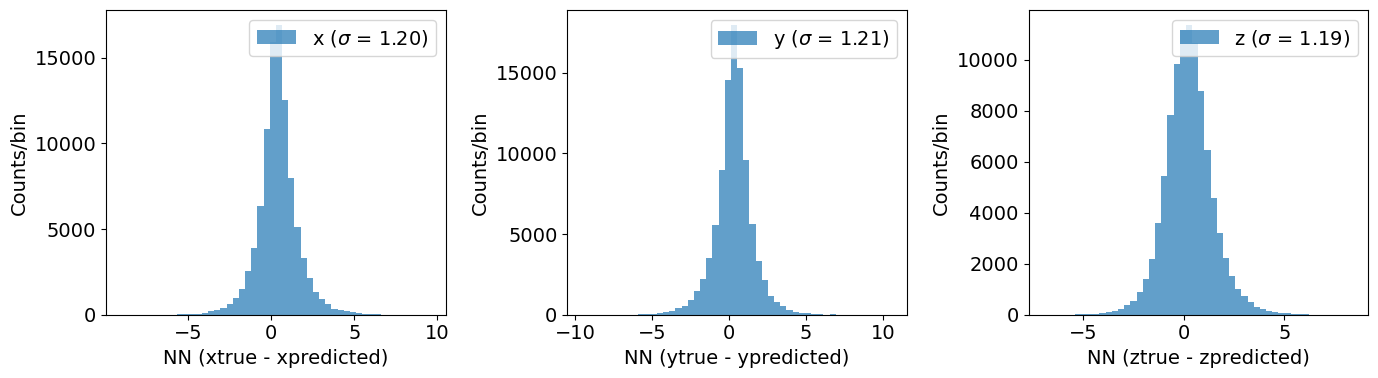

In [53]:
plotxyz(tdeltas, nbins=50)

### Deeper network

In [ ]:
class ResBlock(nn.Module):
    """
    Implements a residual block consisting in [Conv2d->BatchNorm2d->ReLU] + 
    [Conv2d->BatchNorm2d]. This residual is added to the input (then a second activation ReLU applied)
    
    If downsample = None (e.g, default first pass), then we obtain f(x) + x where 
    f(x) -> [Conv2d->BatchNorm2d->ReLU ->Conv2d->BatchNorm2d]. Otherwise the block is skipped. 
    
    """
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                                  stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                                  stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x # This is the residual (in the case of no downsample)
        out = self.conv1(x)
        out = self.conv2(out)
        
        if self.downsample:  # this is the residual in the case of downsample
            residual = self.downsample(x)
            
        out += residual # This is it! f(x) + x 
        out = self.relu(out)

        return out

In [ ]:
class ResNet10(nn.Module):
    """
    Implements the Residual Network with 34 layers:
    The architecture is like this:
    1. Image passes through a convolution (kernel 3x3) 
    with stride = 1 and padding = 1 which increases the features from 3 to 64 and 
    preserves spatian dimensions, then batch normalization and activation. 
    # (W,H,1) => (W,H,64)
    
    2. The layer architecture is as follows (with a skip connection between each pair of layers) 
        6 layers of convolution 3x3 with 64 features
        8 layers of convolution 3x3 with 128 features (max pool 56 -> 28)
        12 layers of convolution 3x3 with 256 features (max pool 28 -> 24)
        6 layers of convolution 3x3 with 512 features (max pool 14 -> 7)
    3. Then avgpool and fc.
    
    """
    def __init__(self, block, num_classes = 3, dropout=False, dropout_fraction=0.2, debug=False):
        super(ResNet10, self).__init__()
        self.debug = debug
        self.inplanes = 64

        self.conv1 = nn.Sequential(
                        nn.Conv2d(1, 64, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(2, 2)
        self.layer0 = self._make_layer(block, 64, 1, stride = 1, nlyr = 1)
        self.layer1 = self._make_layer(block, 128, 1, stride = 2, nlyr = 2)
        self.layer2 = self._make_layer(block, 256, 1, stride = 2, nlyr = 3)
        self.layer3 = self._make_layer(block, 512, 1, stride = 2, nlyr = 4)
        self.avgpool = nn.AvgPool2d(1, stride=1)
        self.fc = nn.Linear(512, num_classes)
        self.dropout = dropout
        self.drop1 = nn.Dropout(p=dropout_fraction)

           
    def _make_layer(self, block, planes, blocks, stride, nlyr):
        downsample = None
        
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        if self.debug:
            print(f" ## make_layer {nlyr}: planes = {planes},  blocks = {blocks}, stride = {stride}")
            print(f" ## make_layer: in_planes={self.inplanes}")
            print(f" ## make_layer: downsample = {downsample}")
            #print(f"layer block = 0: Block(in_channels={self.inplanes}, out_channels ={planes}, stride = {stride}, downsample = {downsample}")
            
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
            if self.debug:
                print(f" layer block = {i}: Block(in_channels={self.inplanes}, out_channels ={planes}, stride = 1, downsample = None")

        return nn.Sequential(*layers)
    
    def forward(self, x):
        if(self.debug): print(f" ResNet10: input data shape =>{x.shape}")
            
        x = self.conv1(x)
        if(self.debug): print(f" ResNet10: after conv1 =>{x.shape}")
            
        #x = self.maxpool(x)
        #if(self.debug): print(f" ResNet: after maxpool =>{x.shape}")
            
        x = self.layer0(x)
        if(self.debug): print(f" ResNet10: after layer0 =>{x.shape}")
        
        x = self.layer1(x)
        if(self.debug): print(f" ResNet10: after layer1 =>{x.shape}")
            
        x = self.layer2(x)
        if(self.debug): print(f" ResNet10: after layer2 =>{x.shape}")
            
        x = self.layer3(x)
        if(self.debug): print(f" ResNet10: after layer3 =>{x.shape}")
            
        x = self.avgpool(x)
        if(self.debug): print(f" ResNet10: after avgpool =>{x.shape}")

        x = x.flatten(start_dim=1)
        #x = x.view(x.size(0), -1)
        if(self.debug): print(f" ResNet10: after flatten =>{x.shape}")
        
        if self.dropout: x = self.drop1(x)  # drop
        x = self.fc(x)
        if(self.debug): print(f" ResNet10: after fc =>{x.shape}")

        self.debug = False
        return x
  

In [ ]:
#define the model
model = ResNet10(ResBlock, debug=True).to(device)

In [ ]:
print(model)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [ ]:
single_run(train_loader, device, model, optimizer,criterion)

In [ ]:
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    model, optimizer, device, criterion, 
                                    batch_size=500, epochs=10, iprnt=200)

In [ ]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))


In [ ]:
plotxyz(tdeltas, nbins=50)

In [ ]:
first_file = 0  # initial file indx
last_file  = 100  # lasta file indx
batch_size = 250  # Batch size
train_fraction=0.7 
val_fraction=0.2
dataset = MonoDataset(CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_NX, 
                      first_file, last_file,
                      norm=True, resize=False, mean=165.90, std=93.3)
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)   


In [ ]:
model = ResNet10(ResBlock, debug=False, dropout=True, dropout_fraction=0.2).to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [ ]:
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    model, optimizer, device, criterion, 
                                    batch_size=batch_size, epochs=10, iprnt=400)

In [ ]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))


In [ ]:
tdeltas = evaluate_cnn(test_loader, model, device)
plotxyz(tdeltas, nbins=50)

## Calculation of means

In [27]:
means, stds = get_means_stds(dir=BGO_6x6_fullwrap_4d5k_2MHzDC_PTFE_LUT_NX)

files in dir: 96
shape -> (10000, 8, 8)
mean img0 =18.171875
std  img0 =24.51119613647461


In [28]:
len(means)

96

In [29]:
means[0][0]

18.34375

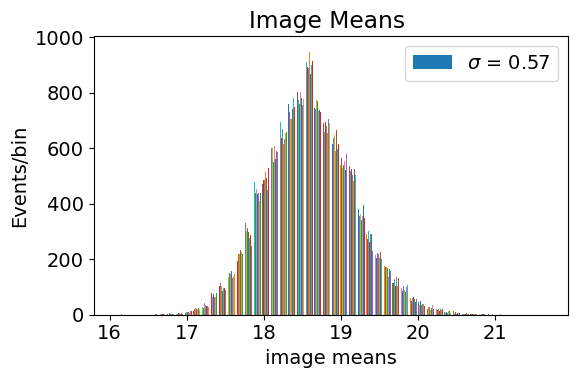

In [30]:
histoplot(means, "image means", vart="Image Means ", num_bins = 50, figsize=(6, 4))

In [31]:
meansx =[np.mean(x) for x in means]

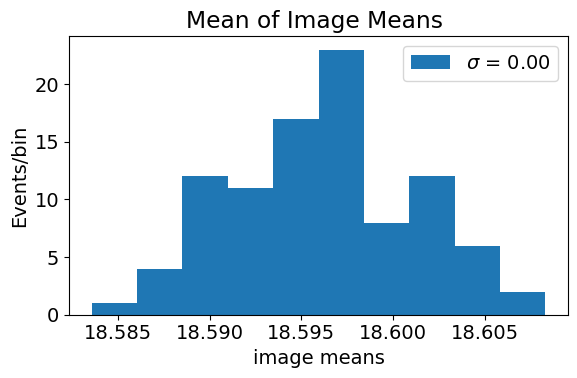

In [32]:
histoplot(meansx, "image means", vart="Mean of Image Means ", num_bins = 10, figsize=(6, 4))

In [33]:
np.mean(meansx)

18.596199

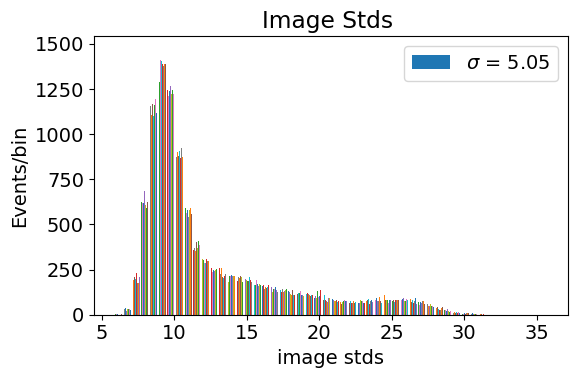

In [34]:
histoplot(stds, "image stds", vart="Image Stds ", num_bins = 50, figsize=(6, 4))

In [35]:
stdsx =[np.std(x) for x in stds]

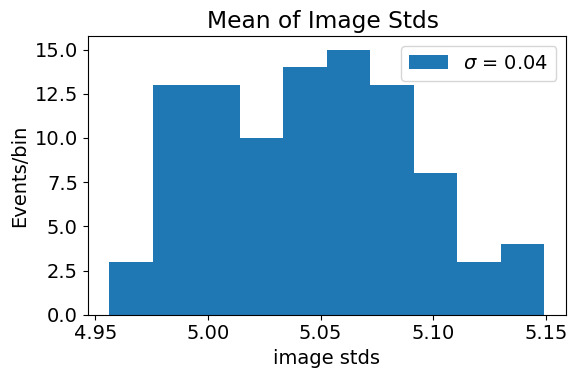

In [36]:
histoplot(stdsx, "image stds", vart="Mean of Image Stds ", num_bins = 10, figsize=(6, 4))

In [37]:
np.mean(stdsx)

5.0451703